In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

# Define the Encoder class
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.bn1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.bn2(x)

        x = self.conv3(x)
        x = self.relu(x)

        return x

# Define the Decoder class
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv1 = nn.ConvTranspose2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), 1, 7, 7)  # Reshape the input before applying convolution transpose
        x = self.conv1(x)
        x = self.relu(x)
        x = self.bn1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.bn2(x)

        x = self.conv3(x)
        x = self.relu(x)

        return x

# Define the Classifier class
class Classifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.25):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Define the Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Define the AutoencoderClassifier class
# Combine Encoder, Decoder, and Classifier into an AutoencoderClassifier class
class AutoencoderClassifier(nn.Module):
    def __init__(self, encoder, decoder, classifier):
        super(AutoencoderClassifier, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.classifier = classifier

    def forward(self, x):
        x = self.encoder(x)
        x_reconstructed = self.decoder(x)
        x_classification = self.classifier(x.view(x.size(0), -1))  # Flatten before classification
        return x_reconstructed, x_classification

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize encoder, decoder, and classifier models
encoder = Encoder().to(device)
decoder = Decoder().to(device)

# Calculate the flattened size for the classifier input
classifier_input_size = 7 * 7 * encoder.conv3.out_channels

classifier = Classifier(input_size=classifier_input_size, hidden_size=128, output_size=10).to(device)

# Combine them into AutoencoderClassifier
autoencoder_classifier = AutoencoderClassifier(encoder, decoder, classifier).to(device)

# Initialize criterion and optimizer
criterion_encoder_decoder = nn.MSELoss()
criterion_classifier = nn.CrossEntropyLoss()
optimizer = optim.Adam(autoencoder_classifier.parameters(), lr=0.001)

# Add scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training loop
num_epochs = 10

epochs_iterator = tqdm(range(num_epochs), desc='Epochs')
for epoch in epochs_iterator:
    autoencoder_classifier.train()
    running_loss_encoder_decoder = 0.0
    running_loss_classifier = 0.0

    data_iterator = tqdm(enumerate(train_loader), desc='Batches', total=len(train_loader), leave=False)

    for batch_idx, (data, labels) in data_iterator:
        data, labels = data.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs_reconstructed, outputs_classification  = autoencoder_classifier(data)


        # Calculate losses
        loss_encoder_decoder = criterion_encoder_decoder(outputs_reconstructed, data)
        loss_classifier = criterion_classifier(outputs_classification, labels)

        # Backward pass
        loss_encoder_decoder.backward(retain_graph=True)
        loss_classifier.backward()

        # Optimize
        optimizer.step()

        # Update running losses
        running_loss_encoder_decoder += loss_encoder_decoder.item()
        running_loss_classifier += loss_classifier.item()

        data_iterator.set_description(
            f'Epoch {epoch + 1}/{num_epochs}, '
            f'Encoder-Decoder Loss: {loss_encoder_decoder.item():.5f}, '
            f'Classifier Loss: {loss_classifier.item():.5f}'
        )

    # Step scheduler
    scheduler.step()

    epoch_loss_encoder_decoder = running_loss_encoder_decoder / len(train_loader)
    epoch_loss_classifier = running_loss_classifier / len(train_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Encoder-Decoder Loss: {epoch_loss_encoder_decoder:.5f}, '
          f'Classifier Loss: {epoch_loss_classifier:.5f}')

    # Evaluation on the test set
    autoencoder_classifier.eval()
    total = 0
    correct = 0
    predicted_labels = []

    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            _, outputs = autoencoder_classifier(data)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            predicted_labels.extend(predicted.cpu().numpy())

    test_acc = 100 * correct / total
    print(f'Test Accuracy: {test_acc:.2f}')


100%|██████████| 9912422/9912422 [00:00<00:00, 94444747.63it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 42075614.39it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29046528.92it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 26204303.67it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [1/10], Encoder-Decoder Loss: 0.04042, Classifier Loss: 0.30623
Test Accuracy: 96.92


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [2/10], Encoder-Decoder Loss: 0.02530, Classifier Loss: 0.10358
Test Accuracy: 97.62


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [3/10], Encoder-Decoder Loss: 0.02341, Classifier Loss: 0.08143
Test Accuracy: 98.25


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [4/10], Encoder-Decoder Loss: 0.02233, Classifier Loss: 0.06755
Test Accuracy: 98.27


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [5/10], Encoder-Decoder Loss: 0.02147, Classifier Loss: 0.05961
Test Accuracy: 98.26


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [6/10], Encoder-Decoder Loss: 0.02038, Classifier Loss: 0.03880
Test Accuracy: 98.58


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [7/10], Encoder-Decoder Loss: 0.01980, Classifier Loss: 0.03418
Test Accuracy: 98.68


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [8/10], Encoder-Decoder Loss: 0.01950, Classifier Loss: 0.03207
Test Accuracy: 98.59


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [9/10], Encoder-Decoder Loss: 0.01924, Classifier Loss: 0.03029
Test Accuracy: 98.68


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch [10/10], Encoder-Decoder Loss: 0.01908, Classifier Loss: 0.02853
Test Accuracy: 98.58


Test Accuracy: 98.58


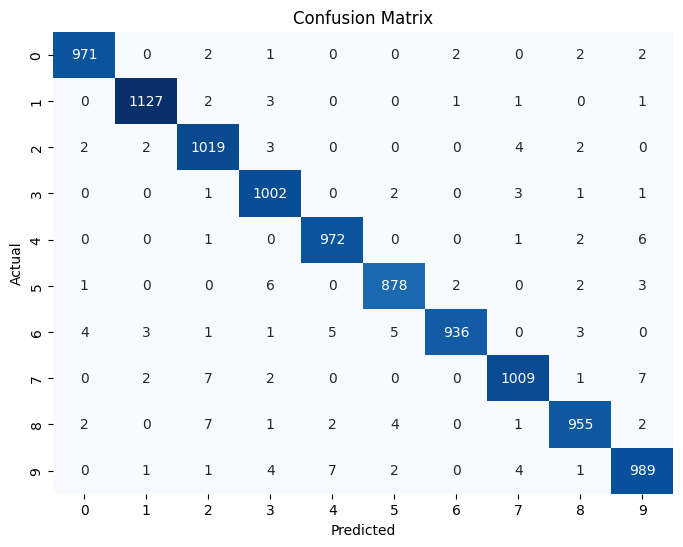

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.99      0.98      0.98      1028
           8       0.99      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [2]:
# Initialize variables for confusion matrix
all_targets = []
all_predicted_labels = []

# Evaluation on the test set
autoencoder_classifier.eval()
total = 0
correct = 0

with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        _, outputs = autoencoder_classifier(data)

        # Only use the classification output during evaluation
        outputs_classification = outputs

        _, predicted = torch.max(outputs_classification, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

        # Append targets and predicted labels for confusion matrix calculation
        all_targets.extend(targets.cpu().numpy())
        all_predicted_labels.extend(predicted.cpu().numpy())

test_acc = 100 * correct / total
print(f'Test Accuracy: {test_acc:.2f}')

# Convert the lists of targets and predicted labels to numpy arrays
all_targets = np.array(all_targets)
all_predicted_labels = np.array(all_predicted_labels)

# Plot confusion matrix
cm = confusion_matrix(all_targets, all_predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(all_targets, all_predicted_labels))


In [10]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
es = accuracy_score(all_targets, all_predicted_labels)

# Calculate the margin of error
margin_of_error = 1.96 * np.sqrt(es * (1 - es) / len(all_targets))

# Calculate the confidence interval
confidence_interval = (es - margin_of_error, es + margin_of_error)

print(f"95% Confidence Interval: {confidence_interval}")

95% Confidence Interval: (0.983481032562195, 0.988118967437805)
